In [74]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated,Literal
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
import operator

In [ ]:
from typing import List, Literal


class MangaFeatureSchema(BaseModel):
    main_characters: List[str] = Field(
        ..., description="List of main characters in the story, including roles or names."
    )
    
    character_descriptions: List[str] = Field(
        ..., description="Short descriptions of the characters’ traits, personalities, or roles."
    )
    
    setting: str = Field(
        ..., description="The primary setting or environment where the story takes place."
    )
    
    conflict_or_goal: str = Field(
        ..., description="The main conflict, tension, or goal driving the story."
    )
    
    important_objects: List[str] = Field(
        ..., description="Key objects, weapons, or magical items relevant to the story."
    )
    
    mood_and_tone: List[
        Literal["dramatic", "mysterious", "adventurous", "romantic", "comedic", "emotional", "dark"]
    ] = Field(
        ..., description="Keywords describing the mood and tone of the story."
    )
    
    key_sound_effects_and_emotions: List[str] = Field(
        ..., description="Important sound effects (onomatopoeia) and strong emotions expressed in the story."
    )


In [75]:
class SchemaSentiment(BaseModel):
    sentiment:Literal["positive","negative"]=Field(description="sentiment of the review")

In [76]:
class SchemaForDiagnosis(BaseModel):
    issue_type: Literal[
        "technical", "billing", "feedback", "account", "other"
    ] = Field(..., description="Type of issue reported by the user.")
    
    tone: Literal[
        "angry", "polite", "neutral", "frustrated", "curious"
    ] = Field(..., description="User's tone based on their message.")
    
    urgency: Literal[
        "low", "medium", "high", "critical", "immediate"
    ] = Field(..., description="How urgent the issue is based on user input.")

In [77]:
_: bool = load_dotenv(find_dotenv())

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
structured_model=model.with_structured_output(SchemaSentiment)
structured_model_for_Diagnose=model.with_structured_output(SchemaForDiagnosis)

In [78]:
prompt="what is the review of this- I don't like this movie"
structured_model.invoke(prompt)

SchemaSentiment(sentiment='negative')

In [79]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["positive","negative"]
    daignosis:dict
    response:str

In [80]:
def sentiment_output(state:ReviewState)->ReviewState:

    review=state['review']
    prompt=f"what is the sentiment of this review \n {review}"
    output=structured_model.invoke(prompt).sentiment

    return {"sentiment":output}

In [81]:
def check_sentiment(state:ReviewState)->Literal["positive_response","run_diagnosis"]:
    if state['sentiment']=="positive":
        return "positive_response"
    else:
        return "run_diagnosis"

In [82]:
def positive_response(state:ReviewState):
    review=state['review']
    prompt=f"Write a a thank you message with kindness for this review {review}.JUST write thankful message"

    output=model.invoke(prompt).content
    return {"response":output}

def run_diagnosis(state:ReviewState):
    review=state['review']
    prompt=f'''Diagnose the negative review {review} \n 
    And return issue_type,tone and urgency
    '''
    output=structured_model_for_Diagnose.invoke(prompt)

    return {"daignosis":output.model_dump()}


def negative_response(state:ReviewState):
    diagnosis=state["daignosis"]
    prompt=f'''You are a customer support assistant. Based on the following user diagnosis details, write a helpful, empathetic, and professional support message in response to the user:

    1. issue_type: {diagnosis["issue_type"]}
    2. tone: {diagnosis["tone"]}
    3. urgency: {diagnosis["urgency"]}

    Your message should:
    - Acknowledge the user's concern and tone
    - Reflect empathy and urgency appropriately
    - Offer a clear next step or reassurance

        '''
    output=model.invoke(prompt).content

    return {"response":output}


In [83]:
graph=StateGraph(ReviewState)

##NOdes
graph.add_node("sentiment_output",sentiment_output)
graph.add_node("positive_response",positive_response)
graph.add_node("run_diagnosis",run_diagnosis)

graph.add_node("negative_response",negative_response)




graph.add_edge(START,'sentiment_output')
graph.add_conditional_edges('sentiment_output',check_sentiment)
graph.add_edge("positive_response",END)
graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("negative_response",END)



workflow=graph.compile()



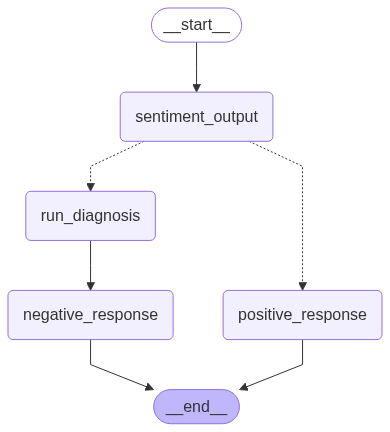

In [84]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [86]:
initial_state={
    'review':"Really disappointed with the service. The app kept crashing, and support took forever to respond. Not what I expected"
}

workflow.invoke(initial_state)

{'review': 'Really disappointed with the service. The app kept crashing, and support took forever to respond. Not what I expected',
 'sentiment': 'negative',
 'daignosis': {'issue_type': 'technical', 'tone': 'angry', 'urgency': 'high'},
 'response': 'Subject: Urgent: Regarding your technical issue - We\'re on it!\n\nDear [User Name - if available, otherwise omit],\n\nI understand you\'re experiencing a technical issue and, judging by your message, that you\'re understandably frustrated. I want to assure you that we take this very seriously and are committed to resolving this for you as quickly as possible.\n\nI know how disruptive technical problems can be, especially when time is of the essence. Please know that your issue has been flagged as high priority and I\'m personally making sure it gets immediate attention.\n\nTo help us get to the bottom of this right away, could you please [Insert specific next step, e.g., "reply to this email with your account ID" or "provide a screenshot 